<h1 align="center">Recurrent Neural Networks</h1>

## Integrantes

- Josué Say
- Andre Jo

## Repositorio

- [Enlace a GitHub](https://github.com/JosueSay/labs_dl/tree/main/lab4)
- [Documentación sobre RNN y dataset Sunspots](https://github.com/JosueSay/labs_dl/blob/main/lab4/docs/investigacion.md)

In [ ]:
# %pip install -r requirements.txt

## Librerias y Constantes

In [18]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

In [19]:
# Configuración general
DATA_PATH = "sunspot.csv"
SEPARATOR = ";"
RANDOM_SEED = 42
LR = 1e-2
EPOCHS = 50
HIDDEN_SIZE = 16
WINDOWS = {"small": 5, "medium": 20, "large": 100}

# Semillas para reproducibilidad
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

## Carga y esquema de columnas

Se lee el archivo CSV oficial del **Sunspot Index and Long-term Solar Observations (SILSO/SIDC)** en su versión diaria v2.0.  
El dataset está separado por `;` y no incluye encabezados, por lo que se asignan nombres manualmente a las 8 columnas según la documentación oficial:

1. **year** -> Año de la observación.  
2. **month** -> Mes de la observación.  
3. **day** -> Día de la observación.  
4. **decimal_date** -> Fecha en formato decimal (ej. 2000.5 ≈ mitad del año 2000).  
5. **sunspot** -> Número diario de manchas solares (puede ser -1 si falta el dato).  
6. **std** -> Desviación estándar asociada al valor.  
7. **n_obs** -> Número de observaciones disponibles ese día.  
8. **flag_def** -> Indicador de método/definición usada para calcular el valor.  

In [20]:
def loadCsv(path):
    # Esquema CSV SIDC diario v2.0: 8 columnas separadas por ';'
    cols = ["year","month","day","decimal_date","sunspot","std","n_obs","flag_def"]
    df = pd.read_csv(path, sep=SEPARATOR, header=None, names=cols)
    return df

data = loadCsv(DATA_PATH)
data.head()

,year,month,day,decimal_date,sunspot,std,n_obs,flag_def
0,1818,1,1,1818.001,-1,-1.0,0,1
1,1818,1,2,1818.004,-1,-1.0,0,1
2,1818,1,3,1818.007,-1,-1.0,0,1
3,1818,1,4,1818.010,-1,-1.0,0,1
4,1818,1,5,1818.012,-1,-1.0,0,1


## Limpieza de faltantes

En el dataset, los valores de manchas solares faltantes están codificados con **-1** en la columna `sunspot`.  
Estos valores no representan observaciones reales, por lo que deben ser tratados antes de entrenar modelos.  

La estrategia utilizada es **eliminación de filas**:  
- Se filtran todas las observaciones con `sunspot >= 0`.  
- Se descartan las filas con `sunspot == -1`.  
- Se reinicia el índice del DataFrame para mantener la secuencia continua.  

In [21]:
def dropMissingSunspots(df):
    return df[df["sunspot"] >= 0].reset_index(drop=True)

data_clean = dropMissingSunspots(data)

## Partición temporal

Dado que los datos corresponden a una **serie temporal** (valores diarios de manchas solares), no se pueden mezclar de forma aleatoria como en otros problemas de machine learning.  
Para mantener la coherencia temporal y evitar fuga de información, se divide el dataset de forma **secuencial**:

1. **Entrenamiento (70%)** -> Primer bloque de observaciones, usado para ajustar los parámetros del modelo.  
2. **Validación (15%)** -> Bloque intermedio, utilizado para ajustar hiperparámetros y prevenir sobreajuste.  
3. **Prueba (15%)** -> Último bloque, reservado exclusivamente para evaluar el desempeño final del modelo en datos no vistos.  

La función `splitTemporal` recibe proporciones de partición y retorna tres subconjuntos (`train`, `val`, `test`) garantizando que siempre se respete el orden cronológico original de la serie.

In [22]:
def splitTemporal(df, train_ratio=0.7, val_ratio=0.15):
    n = len(df)
    n_train = int(n * train_ratio)
    n_val = int(n * val_ratio)

    train = df.iloc[:n_train].copy()
    val   = df.iloc[n_train:n_train+n_val].copy()
    test  = df.iloc[n_train+n_val:].copy()
    return train, val, test

train_df, val_df, test_df = splitTemporal(data_clean)

## Normalización

En este caso, se utiliza una **normalización Min-Max**:

1. **Ajuste del escalador (`fitScaler`)**  
   - Se calcula el valor mínimo y máximo de la serie **únicamente en el conjunto de entrenamiento**.  
   - Esto evita **data leakage** (fuga de información del futuro hacia el pasado).  

2. **Aplicación del escalador (`applyScaler`)**  
   - Cada valor de la serie se transforma a:  
     $$
     x' = \frac{x - \text{min}}{\text{max} - \text{min}}
     $$
   - Resultado: todos los valores quedan en el rango **[0, 1]**.  

3. **Uso en todos los conjuntos**  
   - Se aplica la misma transformación (con min y max del *train*) sobre validación y prueba.  
   - Así se asegura consistencia en la escala entre datasets.  

Se agregan nuevas columnas `sunspot_norm` en `train_df`, `val_df` y `test_df` que contienen los valores normalizados.

In [23]:
def fitScaler(train_series):
    min_v = float(train_series.min())
    max_v = float(train_series.max())
    return {"min": min_v, "max": max_v}

def applyScaler(series, scaler):
    return (series - scaler["min"]) / (scaler["max"] - scaler["min"] + 1e-12)


scaler = fitScaler(train_df["sunspot"])
train_df["sunspot_norm"] = applyScaler(train_df["sunspot"], scaler)
val_df["sunspot_norm"]   = applyScaler(val_df["sunspot"], scaler)
test_df["sunspot_norm"]  = applyScaler(test_df["sunspot"], scaler)

## Ventaneo

Para entrenar una RNN en series temporales se transforma la serie original en subsecuencias de longitud fija que sirvan como entradas, junto con el valor inmediatamente siguiente como objetivo.  
Este proceso se conoce como *sliding window* o **ventaneo**.

1. **Función `createSequences`**  
   - Recorre la serie normalizada creando pares `(X, y)`:
     - `X`: una ventana de tamaño fijo `seq_length`.  
     - `y`: el valor que sigue inmediatamente después de esa ventana.  
   - Convierte las secuencias a tensores PyTorch con dimensiones:  
     - `X`: `[batch_size, seq_length, 1]`  
     - `y`: `[batch_size, 1]`  

2. **Función `makeSplitsForSeq`**  
   - Aplica `createSequences` a los tres subconjuntos (`train`, `val`, `test`).  
   - Retorna las secuencias listas para alimentar a la RNN en cada fase del entrenamiento.  

De esta forma, la red aprende a predecir el siguiente valor de manchas solares a partir de los valores de los últimos `seq_length` días.


In [24]:
def createSequences(array_1d, seq_length):
    xs, ys = [], []
    for i in range(len(array_1d) - seq_length):
        x = array_1d[i:i+seq_length]
        y = array_1d[i+seq_length]
        xs.append(x)
        ys.append(y)
    X = torch.tensor(np.stack(xs), dtype=torch.float32).unsqueeze(-1)  # [batch, seq_len, 1]
    y = torch.tensor(np.stack(ys), dtype=torch.float32).unsqueeze(-1)  # [batch, 1]
    return X, y

def makeSplitsForSeq(df_train, df_val, df_test, seq_length):
    Xtr, ytr = createSequences(df_train["sunspot_norm"].values, seq_length)
    Xva, yva = createSequences(df_val["sunspot_norm"].values, seq_length)
    Xte, yte = createSequences(df_test["sunspot_norm"].values, seq_length)
    return (Xtr, ytr), (Xva, yva), (Xte, yte)

## Modelo RNN

Se define una red neuronal recurrente básica en PyTorch para predecir valores futuros de la serie de manchas solares.

1. **Clase `RnnModel`**
   - **Entrada:** secuencias de dimensión `[batch_size, seq_length, input_size]`.  
   - **Capa recurrente (`nn.RNN`):**
     - `input_size=1` → solo se ingresa una característica por paso temporal (el valor normalizado de manchas solares).  
     - `hidden_size=HIDDEN_SIZE` → número de unidades ocultas que capturan la dinámica temporal.  
     - `batch_first=True` → asegura que la dimensión de batch sea la primera (formato `[batch, seq_len, features]`).  
   - **Capa densa (`nn.Linear`):**
     - Recibe la representación oculta del último paso de la secuencia.  
     - Produce una salida escalar (`output_size=1`), correspondiente al valor predicho del siguiente día.  

2. **Método `forward`**
   - Pasa la secuencia completa por la capa RNN, obteniendo salidas para cada paso temporal.  
   - Selecciona la salida del **último paso temporal** (`out[:, -1, :]`) como resumen de la ventana.  
   - Pasa este vector por la capa fully connected (`fc`) para generar la predicción final.  

In [25]:
class RnnModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=HIDDEN_SIZE, output_size=1):
        super().__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc  = nn.Linear(hidden_size, output_size)
    def forward(self, x):
        out, _ = self.rnn(x)             # out: [batch, seq_len, hidden]
        out = out[:, -1, :]              # último paso temporal
        out = self.fc(out)               # [batch, output_size]
        return out

## Experimentos por tamaño de ventana

El objetivo es comparar el desempeño de la RNN al entrenar con diferentes **longitudes de ventana temporal** (5, 20, 100 días).  
Para ello, se definen dos funciones principales:

1. **Entrenamiento (`trainOneSplit`)**
   - Configura la función de pérdida MSE (Error Cuadrático Medio) y el optimizador Adam.  
   - Ciclo de entrenamiento:
     - Modo entrenamiento: realiza forward pass, calcula pérdida de entrenamiento, retropropagación de gradientes y actualización de parámetros.  
     - Modo validación: evalúa la pérdida en el conjunto de validación sin actualizar parámetros.  
   - Registra en `history` las pérdidas `(train_loss, val_loss)` por cada época.  
   - Muestra avances cada 10 épocas con métricas de entrenamiento y validación.

2. **Evaluación (`evaluateModel`)**
   - Cambia a modo evaluación (`model.eval()`).  
   - Calcula las predicciones sobre el conjunto de prueba.  
   - Devuelve:
     - Predicciones como arreglo NumPy.  
     - Valores reales de prueba.  
     - MSE final sobre el conjunto de prueba.  

Este bloque permite comparar cómo varía el rendimiento de la RNN al cambiar el tamaño de la ventana, registrando tanto curvas de entrenamiento/validación como métricas en el conjunto de prueba.

In [26]:
def trainOneSplit(model, Xtr, ytr, Xva, yva, epochs=EPOCHS, lr=LR):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    history = []
    for epoch in range(1, epochs+1):
        model.train()
        optimizer.zero_grad()
        preds = model(Xtr)
        loss = criterion(preds, ytr)
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            val_loss = criterion(model(Xva), yva).item()
        history.append((loss.item(), val_loss))
        if epoch % 10 == 0:
            print(f"Epoch {epoch}/{epochs} | train MSE={loss.item():.6f} | val MSE={val_loss:.6f}")
    return history

def evaluateModel(model, Xte, yte):
    model.eval()
    with torch.no_grad():
        preds = model(Xte)
        mse = nn.MSELoss()(preds, yte).item()
    return preds.squeeze(-1).numpy(), yte.squeeze(-1).numpy(), mse


## Experimentos por tamaño de ventana

Se ejecutan experimentos completos con diferentes longitudes de ventana (`5`, `20`, `100`) para observar cómo afecta el historial de datos usado a la capacidad predictiva de la RNN.

1. **Función `runExperiment`**
   - **Preparación de datos:** genera los tensores de entrada/salida para entrenamiento, validación y prueba a partir del tamaño de ventana (`seq_length`).  
   - **Definición del modelo:** instancia un `RnnModel` con los parámetros establecidos.  
   - **Entrenamiento:** entrena el modelo con `trainOneSplit`, registrando pérdidas en train y val.  
   - **Evaluación:** obtiene predicciones y calcula el **MSE** sobre el conjunto de prueba.  
   - **Visualización:** grafica en una figura la serie real vs. la predicha, mostrando en el título el tamaño de ventana y el error obtenido.

2. **Ejecución en bucle**
   - Recorre las configuraciones de ventana definidas en `WINDOWS` (`small=5`, `medium=20`, `large=100`).  
   - Llama a `runExperiment` para cada caso, generando gráficos comparativos que permiten observar:  
     - Precisión relativa en cada escenario.  
     - Diferencias en la estabilidad del entrenamiento.  
     - Impacto de la longitud de la secuencia en la calidad de la predicción.

Con esto se obtiene una serie de gráficos y métricas que facilitan la comparación entre ventanas pequeñas, medianas y grandes, base para el análisis final de desempeño y problemas como *vanishing* o *exploding gradients*.


Epoch 10/50 | train MSE=0.015615 | val MSE=0.027024
Epoch 20/50 | train MSE=0.012747 | val MSE=0.009963
Epoch 30/50 | train MSE=0.003904 | val MSE=0.002762
Epoch 40/50 | train MSE=0.003135 | val MSE=0.002557
Epoch 50/50 | train MSE=0.002552 | val MSE=0.001838


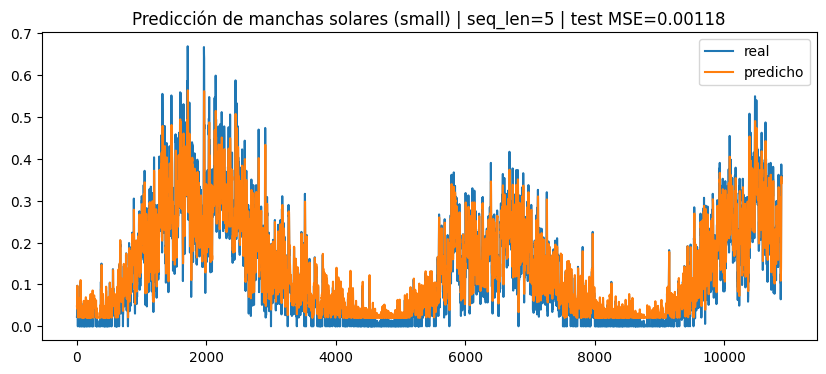

Epoch 10/50 | train MSE=0.016456 | val MSE=0.025981
Epoch 20/50 | train MSE=0.010057 | val MSE=0.007008
Epoch 30/50 | train MSE=0.004547 | val MSE=0.002633
Epoch 40/50 | train MSE=0.002611 | val MSE=0.002202
Epoch 50/50 | train MSE=0.002533 | val MSE=0.001872


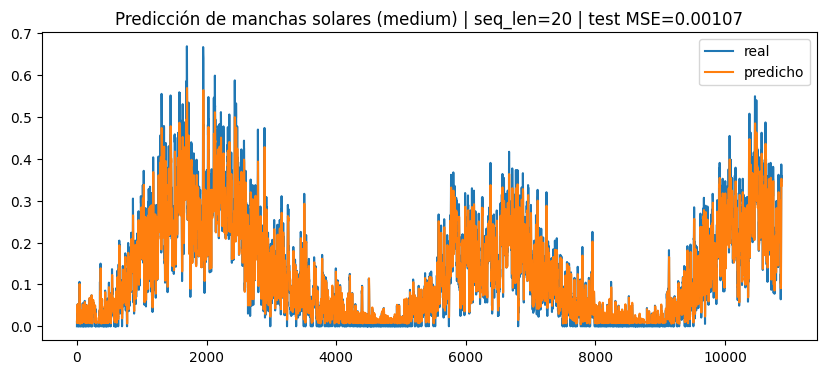

Epoch 10/50 | train MSE=0.017827 | val MSE=0.019269
Epoch 20/50 | train MSE=0.006710 | val MSE=0.008514
Epoch 30/50 | train MSE=0.004201 | val MSE=0.003029
Epoch 40/50 | train MSE=0.002919 | val MSE=0.002018
Epoch 50/50 | train MSE=0.002693 | val MSE=0.001853


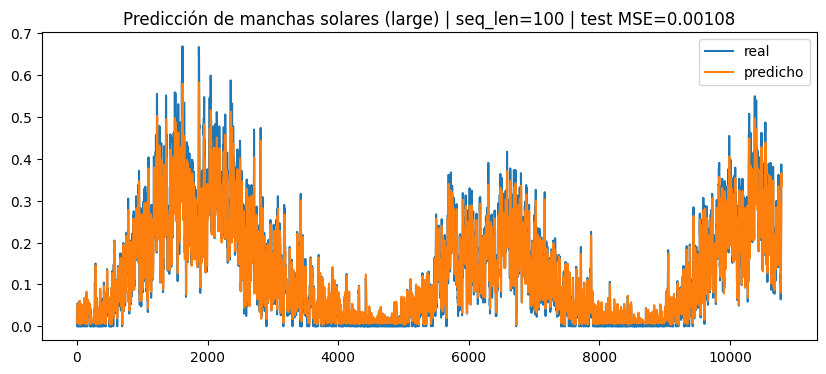

In [27]:
def runExperiment(seq_length, title):
    (Xtr, ytr), (Xva, yva), (Xte, yte) = makeSplitsForSeq(train_df, val_df, test_df, seq_length)
    model = RnnModel(input_size=1, hidden_size=HIDDEN_SIZE, output_size=1)
    _ = trainOneSplit(model, Xtr, ytr, Xva, yva, epochs=EPOCHS, lr=LR)
    preds, target, mse = evaluateModel(model, Xte, yte)

    plt.figure(figsize=(10,4))
    plt.plot(target, label="real")
    plt.plot(preds, label="predicho")
    plt.title(f"{title} | seq_len={seq_length} | test MSE={mse:.5f}")
    plt.legend()
    plt.show()

for tag, slen in WINDOWS.items():
    runExperiment(slen, f"Predicción de manchas solares ({tag})")

## Referencias

- [RNN Documentation (PyTorch)](https://docs.pytorch.org/docs/stable/generated/torch.nn.RNN.html)
- [LSTM Documentation (PyTorch)](https://docs.pytorch.org/docs/stable/generated/torch.nn.LSTM.html)
- [Dataset Sunspots (WDC-SILSO)](https://www.sidc.be/SILSO/datafiles)
- [Información detallada del dataset diario (SILSO)](https://www.sidc.be/SILSO/infosndtot)